In [72]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  

Neural Network Model for Hyper Parameter Tuning

In [73]:
def benchmark(X, Y):
    return -((X**2 + Y - 11)**2 + (X + Y**2 - 7)**2)


In [74]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 5

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [75]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, y, a, b: 0.1 * (a - 4) * x + 0.05 * (b + 3) * y**2 + 0.03 * x * y + r.normal(0, sim_stdev)

In [76]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-5, 5, 5)
Y = np.random.uniform(-5, 5, 5)

# Calculate the outputs using Himmelblau's Function
output1 = benchmark(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset of Physical Experiments
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [77]:
df

,x,y,z
0,-0.829780,-4.076614,-284.253932
1,2.203245,-3.137398,-111.669530
2,-4.998856,-1.544393,-247.301416
3,-1.976674,-1.032325,-128.722651
4,-3.532441,0.388167,-111.174208


In [78]:
sim_eval = lambda x, y, a, b: benchmark(x, y) + sim_err(x, y, a, b)

In [79]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 4.32432971 -3.06924425]


In [80]:
df_sim = df.copy()

df_sim

,x,y,z,a,b,sim_z,diff
0,-0.829780,-4.076614,-284.253932,4.32433,-3.069244,-282.256649,-1.997283
1,2.203245,-3.137398,-111.669530,4.32433,-3.069244,-113.354470,1.684940
2,-4.998856,-1.544393,-247.301416,4.32433,-3.069244,-242.011988,-5.289428
3,-1.976674,-1.032325,-128.722651,4.32433,-3.069244,-126.540507,-2.182144
4,-3.532441,0.388167,-111.174208,4.32433,-3.069244,-107.847611,-3.326597


In [81]:
df

,x,y,z,a,b,sim_z,diff
0,-0.829780,-4.076614,-284.253932,4.32433,-3.069244,-282.256649,-1.997283
1,2.203245,-3.137398,-111.669530,4.32433,-3.069244,-113.354470,1.684940
2,-4.998856,-1.544393,-247.301416,4.32433,-3.069244,-242.011988,-5.289428
3,-1.976674,-1.032325,-128.722651,4.32433,-3.069244,-126.540507,-2.182144
4,-3.532441,0.388167,-111.174208,4.32433,-3.069244,-107.847611,-3.326597


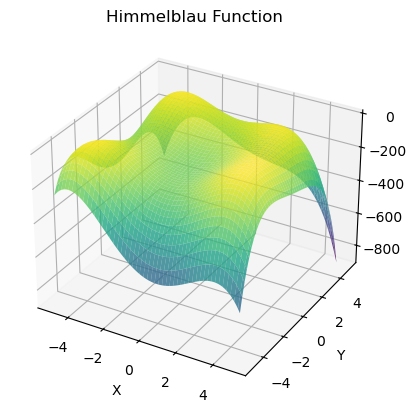

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-5, 5, 100)
y_range = np.linspace(-5, 5, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = benchmark(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Himmelblau Function')

# Show the plot
plt.show()

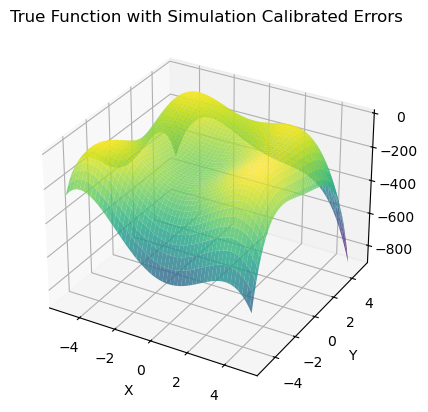

In [83]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [84]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [85]:
df_new = pd.DataFrame

In [86]:
def perform_iteration(df, df2):
    # Define the objective function to minimize
    @use_named_args(hyp_space)
    def objective(**params):
        num_layers = params['num_layers']
        num_units = params['num_units']
        learning_rate = params['learning_rate']
        dropout_rate = params['dropout_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']

        model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
        # Define K-fold cross-validation
        kfold = KFold(n_splits=3, shuffle=True, random_state=0)
        scores = []

        # Perform cross-validation
        for train_idx, val_idx in kfold.split(df[['x', 'y']]):
            X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
            y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

            # Standardize the features
            scaler_x = StandardScaler().fit(X_train)
            X_train_scaled = scaler_x.transform(X_train)
            X_val_scaled = scaler_x.transform(X_val)

            # Train the model
            model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

            # Evaluate the model
            score = model.evaluate(X_val_scaled, y_val, verbose=0)
            scores.append(score)
    
        return np.mean(scores)

    # Perform Bayesian optimization
    result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # Output best hyperparameters from BayesOpt
    print("Best hyperparameters:")
    print("num_layers:", result.x[0])
    print("num_units:", result.x[1])
    print("learning_rate:", result.x[2])
    print("dropout_rate:", result.x[3])
    print("batch_size:", result.x[4])
    print("epochs:", result.x[5])

    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=result.x[0],
        num_units=result.x[1],
        learning_rate=result.x[2],
        dropout_rate=result.x[3]
    )

    # Standardize the initial dataset
    scaler_x = StandardScaler().fit(df[['x', 'y']])
    X_scaled = scaler_x.transform(df[['x', 'y']])

    # Train the best model on the initial dataset
    best_model.fit(X_scaled, df[['sim_z']], epochs=result.x[5], batch_size=result.x[4], verbose=1)

    # Produce Meshgrid of results with C.I. 
    pred_mean, pred_std = mc_dropout_predictions(best_model, X_scaled)

    x1_range = np.linspace(-5, 5, 100)
    x2_range = np.linspace(-5, 5, 100)
    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

    x_grid_scaled = scaler_x.transform(x_grid)

    # Perform MC Dropout predictions for entire meshgrid
    pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid_scaled)

    # Define range for inputs
    bounds = np.array([[-5, 5], [-5, 5]])

    num_top_points = 10

    # Generate Latin Hypercube Samples
    sampler = qmc.LatinHypercube(d=2)  # LHS in a 2D space
    lhs_sample = sampler.random(n=30)
    lhs_points = qmc.scale(lhs_sample, bounds[:, 0], bounds[:, 1])  # Scale to input bounds

    # Perform MC Dropout predictions for LHS points
    lhs_mean, lhs_std = mc_dropout_predictions(best_model, lhs_points)

    # Calculate the Upper Confidence Interval (UCI)
    upper_confidence = lhs_mean + (1.96 * lhs_std)

    # Sort points by their UCI in descending order
    sorted_indices = np.argsort(upper_confidence)[::-1]  # Sort in descending order
    top_indices = sorted_indices[:num_top_points]        # Select indices of the top points

    # Select the top points and their UCI
    selected_points = lhs_points[top_indices]
    selected_upper_confidence = upper_confidence[top_indices]

    # Convert the selected points and UCI into a DataFrame
    new_points_df = pd.DataFrame(selected_points, columns=['x', 'y'])
    df2 = new_points_df
    new_points_df['z'] = selected_upper_confidence  # Add UCI as a column

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x1_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x1_grid.shape)

    mean_surface = ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Plot next candidate points
    ax.scatter(new_points_df['x'], new_points_df['y'], new_points_df['z'], color='black', marker='o', label='Next Sampling Points')

    # Customize the plot
    ax.set_title('Neural Network Predictions with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()

    # Add validated data points to original data frame
    df2["z"] = benchmark(df2['x'], df2['y']) + ran_err(10, 0.05)
    df2["a"] = bo.x_opt[0]
    df2["b"] = bo.x_opt[1]
    df2["sim_z"] = sim_eval(df2["x"], df2["y"], df2["a"], df2["b"])
    df2["diff"] = df2["z"] - df2["sim_z"]

    df = pd.concat([df, df2], axis=0, ignore_index=True)

    # Select 5 candidate points for next physical observation
    df2_sorted = df2.sort_values(by='sim_z', ascending=False)
    df2 = df2_sorted.head(5)

    # Define probability function based on model uncertainty
    # def p(x):
    #     x_reshaped = x.reshape(1, -1)
    #     mean, std = mc_dropout_predictions(best_model, x_reshaped)
    #     mean = mean.ravel() 
    #     std = std.ravel() 
    #      # Check if x stays within x1_range and x2_range
    #     if x_reshaped[0, 0] >= np.min(x1_range) and x_reshaped[0, 0] <= np.max(x1_range) and \
    #     x_reshaped[0, 1] >= np.min(x2_range) and x_reshaped[0, 1] <= np.max(x2_range):
    #         # Compute the upper bound of the 95% confidence interval and compare with the median
    #         return np.max([mean[0] + 1.96 * std[0] - df['sim_z'].median(), 0])
    #     else:
    #         return 0  # Return 0 if the point is outside the valid input space

    # # Metropolis step proposal distribution N(0,sig**2)
    # def metropolis_step(x, sig):
    #     prop_x = x + np.random.normal(0, sig, size=x.shape)
    #     u = np.random.uniform(0, 1)
    #     if u < np.min([1.0, p(prop_x) / p(x)]):
    #         return prop_x
    #     else:
    #         return x

    # # Metropolis-Hastings Sampler
    # def mh_sampler(sig, sample_size, burn_in, lag):
    #     x = np.array([[df["x"].loc[np.argmax(df["sim_z"])], df["y"].loc[np.argmax(df["sim_z"])]]])
    #     for i in range(burn_in):
    #         x = metropolis_step(x, sig)
    #     samples = x
    #     for i in range(sample_size - 1):
    #         for j in range(lag):
    #             x = metropolis_step(x, sig)
    #         samples = np.vstack((samples, x))
    #     return samples

    # # Generate new points using MH sampler
    # sig = 2 
    # sample_size = 10
    # burn_in = 150
    # lag = 15
    # new_points = mh_sampler(sig, sample_size, burn_in, lag)

    # # Convert new points to dataframe
    # df2 = pd.DataFrame(new_points, columns=['x', 'y'])
    # temp_df =  df2

    # # Add simulated responses for new points
    # df2['z'] = benchmark(df2['x'], df2['y']) + ran_err(sample_size, 0.05)
    # df2["a"] = bo.x_opt[0]
    # df2["b"] = bo.x_opt[1]
    # df2["sim_z"] = sim_eval(df2['x'], df2['y'], df2["a"], df2["b"])
    # df2["diff"] = df2["z"] - df2["sim_z"]

    # # Add new points to original dataframe
    # df = pd.concat([df, df2], axis=0, ignore_index=True)

    # # Produce Meshgrid of results with C.I.
    # x1_range = np.linspace(-5, 5, 100)
    # x2_range = np.linspace(-5, 5, 100)

    # x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    # x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

    # x_grid_scaled = scaler_x.transform(x_grid)

    # # Perform MC Dropout predictions for entire meshgrid
    # pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid_scaled)
    
    # # Plotting the predictions with confidence intervals and next sampling points
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')

    # # Reshape predictions back to grid shape
    # pred_mean_grid = pred_mean.reshape(x1_grid.shape)
    # pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x1_grid.shape)
    # pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x1_grid.shape)


    # # Plot the mean prediction surface
    # ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    # # Plot the upper and lower confidence intervals
    # ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    # ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')


    # input_data = df2[['x', 'y']].values
    # predictions = best_model.predict(input_data)  

    # # If the predictions are in a 2D array, flatten to 1D for a single-column addition
    # temp_df["z"] = predictions.ravel()

    # ax.scatter(temp_df["x"], temp_df["y"], temp_df["z"], color='black', marker='o', label='Next Sampling Points')

    # # Customize the plot
    # ax.set_title('Neural Network Predictions with Confidence Intervals')
    # ax.set_xlabel('X')
    # ax.set_ylabel('Y')
    # ax.set_zlabel('Output')

    # # Legend
    # ax.legend(loc='upper left')

    # # Show the plot
    # plt.show()
    return df, df2


Best hyperparameters:
num_layers: 5
num_units: 200
learning_rate: 0.007726721841482657
dropout_rate: 0.5
batch_size: 58
epochs: 145
Epoch 1/145
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 35808.4922
Epoch 2/145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 35660.4648
Epoch 3/145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 35201.3359
Epoch 4/145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 33726.1016
Epoch 5/145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 32150.0898
Epoch 6/145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 26288.6504
Epoch 7/145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 15395.2090
Epoch 8/145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6652.3296
Epoch 9/145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 34055.6719
Epoch 10/145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 12905.7070
Epoch 11/145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 14365.5127
Epoch 12/145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11022.4004
Epoch 13/145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

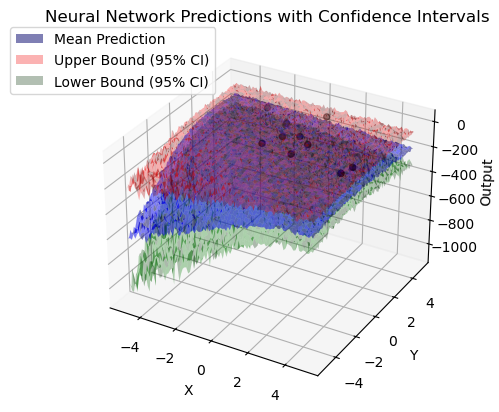

          x         y          z        a         b      sim_z      diff
1 -2.233182  3.405869 -12.407959  4.32433 -3.069244 -12.732731  0.324772
7  3.972293 -0.501130 -25.977078  4.32433 -3.069244 -25.936021 -0.041058
9  4.126547  0.366813 -48.450228  4.32433 -3.069244 -48.215173 -0.235056
4 -0.658692  2.550723 -65.586921  4.32433 -3.069244 -65.663024  0.076103
0  1.410275  0.939082 -87.361970  4.32433 -3.069244 -87.233112 -0.128858
           x         y           z        a         b       sim_z      diff
0  -0.829780 -4.076614 -284.253932  4.32433 -3.069244 -282.256649 -1.997283
1   2.203245 -3.137398 -111.669530  4.32433 -3.069244 -113.354470  1.684940
2  -4.998856 -1.544393 -247.301416  4.32433 -3.069244 -242.011988 -5.289428
3  -1.976674 -1.032325 -128.722651  4.32433 -3.069244 -126.540507 -2.182144
4  -3.532441  0.388167 -111.174208  4.32433 -3.069244 -107.847611 -3.326597
5   1.410275  0.939082  -87.361970  4.32433 -3.069244  -87.233112 -0.128858
6  -2.233182  3.405869  -12.40

In [87]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)
print(df_sim)

Best hyperparameters:
num_layers: 3
num_units: 195
learning_rate: 0.00409788855418806
dropout_rate: 0.08545479256802259
batch_size: 67
epochs: 163
Epoch 1/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 19170.1875
Epoch 2/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 19062.6582
Epoch 3/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 18914.5938
Epoch 4/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 18711.5977
Epoch 5/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 18368.5059
Epoch 6/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 17890.7285
Epoch 7/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 17299.6992
Epoch 8/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 16435.6816
Epoch 9/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 15452.3408
Epoch 10/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 13917.4473
Epoch 11/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 12312.3125
Epoch 12/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 10501.9053
Epoch 13/163
1/1 ━━━━━━━

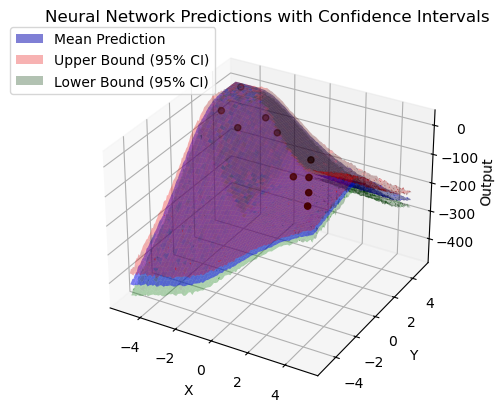

In [88]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 2
num_units: 50
learning_rate: 0.0030863123228114485
dropout_rate: 0.5
batch_size: 21
epochs: 185
Epoch 1/185
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 20138.6699  
Epoch 2/185
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22140.2422 
Epoch 3/185
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19309.9492 
Epoch 4/185
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21911.6016 
Epoch 5/185
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21400.8652 
Epoch 6/185
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21726.3418 
Epoch 7/185
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18920.8027 
Epoch 8/185
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20661.2969 
Epoch 9/185
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18606.5625 
Epoch 10/185
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21137.3867 
Epoch 11/185
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20380.1875 
Epoch 12/185
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18154.0020 
Epoch 13/185
2/2 ━━━━━━━━━━━━━━━━━━━

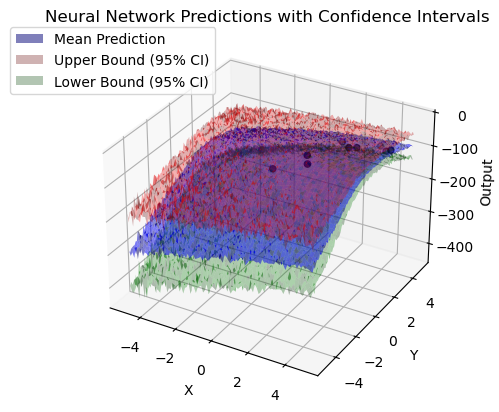

In [89]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 10
num_units: 50
learning_rate: 0.005782661521549666
dropout_rate: 0.0
batch_size: 150
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 21530.2539
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 21517.4902
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 21490.9395
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 21440.2754
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 21333.7969
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 21113.5742
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 20663.6191
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 19770.2129
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 18064.5371
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 15015.4424
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 10349.8652
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6734.1826
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

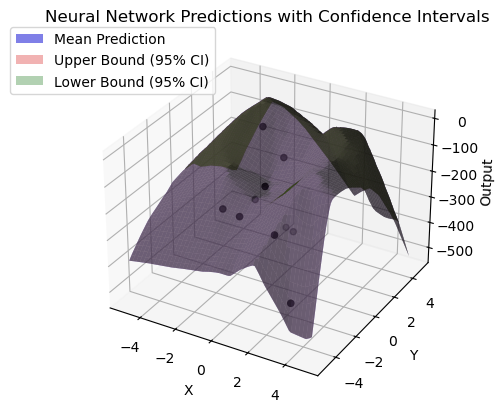

In [90]:
df_sim, df_new = perform_iteration(df_sim, df)

Best hyperparameters:
num_layers: 5
num_units: 200
learning_rate: 0.01304097971625868
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 21005.4941
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21066.8770 
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14196.7188
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13737.6123 
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8831.4912 
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6405.4336 
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5967.1362 
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5781.0371 
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5512.5059 
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4882.1162 
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4129.4536 
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5421.4976 
Epoch 13/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

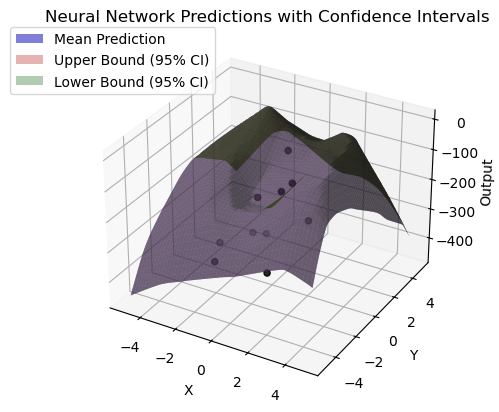

In [91]:
df_sim, df_new = perform_iteration(df_sim, df)


Best hyperparameters:
num_layers: 4
num_units: 50
learning_rate: 0.014818919724497002
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 18378.1699
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16042.7754 
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14798.6328 
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6427.2490 
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7732.0566 
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5022.7554 
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5076.8442 
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4020.5042 
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4891.8418 
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3799.6143 
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3921.1528 
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4548.1274 
Epoch 13/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

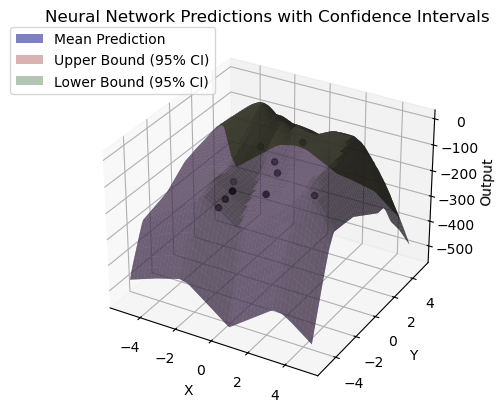

          x         y           z        a         b       sim_z      diff
7  1.408137  1.674622  -61.778106  4.32433 -3.069244  -61.588097 -0.190009
8 -2.938169  1.291807  -69.506575  4.32433 -3.069244  -69.766268  0.259693
1 -1.505307  1.514523  -90.645242  4.32433 -3.069244  -90.841706  0.196463
0  1.126614  0.972365 -101.042503  4.32433 -3.069244 -100.939050 -0.103454
9 -2.433192 -0.970161 -108.685160  4.32433 -3.069244 -108.736305  0.051145
           x         y           z        a         b       sim_z      diff
0  -0.829780 -4.076614 -284.253932  4.32433 -3.069244 -282.256649 -1.997283
1   2.203245 -3.137398 -111.669530  4.32433 -3.069244 -113.354470  1.684940
2  -4.998856 -1.544393 -247.301416  4.32433 -3.069244 -242.011988 -5.289428
3  -1.976674 -1.032325 -128.722651  4.32433 -3.069244 -126.540507 -2.182144
4  -3.532441  0.388167 -111.174208  4.32433 -3.069244 -107.847611 -3.326597
..       ...       ...         ...      ...       ...         ...       ...
60 -1.176894 -1.70

In [92]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)
print(df_sim)

Best hyperparameters:
num_layers: 2
num_units: 129
learning_rate: 0.032880049258074584
dropout_rate: 0.0
batch_size: 20
epochs: 171
Epoch 1/171
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15121.5703  
Epoch 2/171
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7682.8867 
Epoch 3/171
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8340.0000 
Epoch 4/171
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4490.0767 
Epoch 5/171
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6393.8701 
Epoch 6/171
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7423.0029  
Epoch 7/171
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3653.4019 
Epoch 8/171
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4994.0078 
Epoch 9/171
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3872.1973 
Epoch 10/171
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4091.2405 
Epoch 11/171
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4407.7676 
Epoch 12/171
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3336.0112 
Epoch 13/171
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

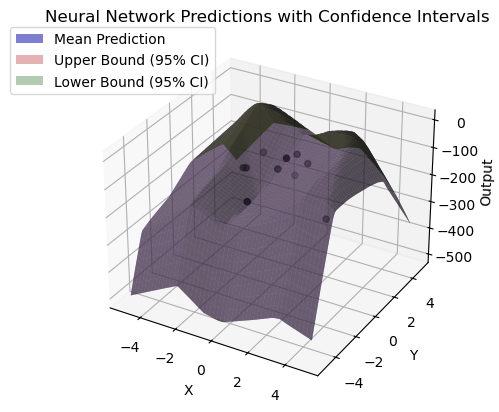

          x         y          z        a         b      sim_z      diff
9  2.282228  1.265894 -30.299581  4.32433 -3.069244 -30.028234 -0.271347
8 -0.247523  2.673048 -68.299534  4.32433 -3.069244 -68.382492  0.082958
6  0.773531  2.116373 -71.651670  4.32433 -3.069244 -71.638533 -0.013137
4 -1.552790  1.845824 -71.804507  4.32433 -3.069244 -72.092801  0.288295
1  0.459612  1.611262 -99.727099  4.32433 -3.069244 -99.753057  0.025958


In [93]:
df_sim, df_new = perform_iteration(df_sim, df)
print(df_new)

In [94]:
df_new

,x,y,z,a,b,sim_z,diff
9,2.282228,1.265894,-30.299581,4.32433,-3.069244,-30.028234,-0.271347
8,-0.247523,2.673048,-68.299534,4.32433,-3.069244,-68.382492,0.082958
6,0.773531,2.116373,-71.651670,4.32433,-3.069244,-71.638533,-0.013137
4,-1.552790,1.845824,-71.804507,4.32433,-3.069244,-72.092801,0.288295
1,0.459612,1.611262,-99.727099,4.32433,-3.069244,-99.753057,0.025958


In [95]:
df

,x,y,z,a,b,sim_z,diff
0,-0.829780,-4.076614,-284.253932,4.32433,-3.069244,-282.256649,-1.997283
1,2.203245,-3.137398,-111.669530,4.32433,-3.069244,-113.354470,1.684940
2,-4.998856,-1.544393,-247.301416,4.32433,-3.069244,-242.011988,-5.289428
3,-1.976674,-1.032325,-128.722651,4.32433,-3.069244,-126.540507,-2.182144
4,-3.532441,0.388167,-111.174208,4.32433,-3.069244,-107.847611,-3.326597


In [96]:
# Assuming df is your DataFrame
average1 = df.iloc[:, -1].mean()

print("Average of the last column:", average1)

Average of the last column: -2.2221023229230723


In [97]:
df = pd.concat([df, df_new], ignore_index=True)
df

,x,y,z,a,b,sim_z,diff
0,-0.829780,-4.076614,-284.253932,4.32433,-3.069244,-282.256649,-1.997283
1,2.203245,-3.137398,-111.669530,4.32433,-3.069244,-113.354470,1.684940
2,-4.998856,-1.544393,-247.301416,4.32433,-3.069244,-242.011988,-5.289428
3,-1.976674,-1.032325,-128.722651,4.32433,-3.069244,-126.540507,-2.182144
4,-3.532441,0.388167,-111.174208,4.32433,-3.069244,-107.847611,-3.326597
5,2.282228,1.265894,-30.299581,4.32433,-3.069244,-30.028234,-0.271347
6,-0.247523,2.673048,-68.299534,4.32433,-3.069244,-68.382492,0.082958
7,0.773531,2.116373,-71.651670,4.32433,-3.069244,-71.638533,-0.013137
8,-1.552790,1.845824,-71.804507,4.32433,-3.069244,-72.092801,0.288295
9,0.459612,1.611262,-99.727099,4.32433,-3.069244,-99.753057,0.025958


In [139]:
df = df.iloc[:, :-4]
df

,x,y,z
0,-0.829780,-4.076614,-284.253932
1,2.203245,-3.137398,-111.669530
2,-4.998856,-1.544393,-247.301416
3,-1.976674,-1.032325,-128.722651
4,-3.532441,0.388167,-111.174208
5,2.282228,1.265894,-30.299581
6,-0.247523,2.673048,-68.299534
7,0.773531,2.116373,-71.651670
8,-1.552790,1.845824,-71.804507
9,0.459612,1.611262,-99.727099


In [140]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
          {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 4.32432971 -3.06924425]


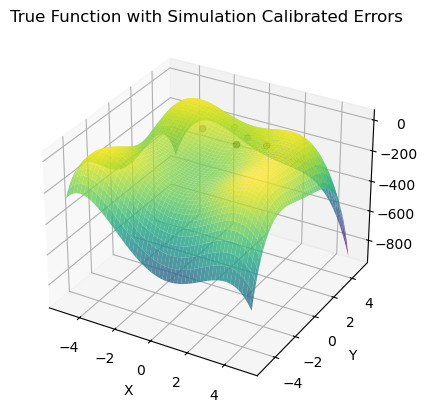

In [141]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_new["x"], df_new["y"], df_new["sim_z"], color='black', marker='o', label='Next Sampling Points')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)


# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [142]:
df

,x,y,z,a,b,sim_z,diff
0,-0.829780,-4.076614,-284.253932,4.32433,-3.069244,-284.491604,0.237671
1,2.203245,-3.137398,-111.669530,4.32433,-3.069244,-111.740501,0.070971
2,-4.998856,-1.544393,-247.301416,4.32433,-3.069244,-247.648674,0.347258
3,-1.976674,-1.032325,-128.722651,4.32433,-3.069244,-128.777750,0.055099
4,-3.532441,0.388167,-111.174208,4.32433,-3.069244,-111.706944,0.532735
5,2.282228,1.265894,-30.299581,4.32433,-3.069244,-29.862404,-0.437177
6,-0.247523,2.673048,-68.299534,4.32433,-3.069244,-68.480841,0.181307
7,0.773531,2.116373,-71.651670,4.32433,-3.069244,-71.625637,-0.026032
8,-1.552790,1.845824,-71.804507,4.32433,-3.069244,-72.256450,0.451943
9,0.459612,1.611262,-99.727099,4.32433,-3.069244,-99.745278,0.018179
